# VAMPNets on Alanine Dipeptide

This example we study the Alanine Dipeptide molecule. Alanine Dipeptide is an example for a small peptide exhibiting rare-events in solution at room temperature. The $\phi$ and $\psi$ dihedral angles of the molecule have been identified as the two relevant coordinates for the slowest kinteic processes of the system under equilibrium conditions. 

Here we seek to recover these relevant coordinates from $(x,y,z)$ atom position data using VAMPNets. To this end, we require a working installation of [PyTorch](https://pytorch.org/) as well as [mdshare](https://markovmodel.github.io/mdshare/) to obtain the data.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar

First, we set up the device. If available, we use CUDA.

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)

Obtain the data via mdshare:

In [13]:
ala_coords_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data"
)
with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory="data"
)
with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

Since the dynamics of the molecule are completely described by its position in the dihedral plane, we can use these two variables to visualize the state population.

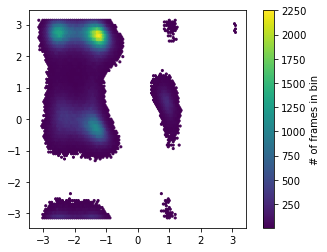

In [14]:
f, ax = plt.subplots(1, 1)
hb = ax.hexbin(*np.concatenate(dihedral).T, mincnt=5)
ax.set_aspect('equal')
cb = f.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')

Let's define the dataset that we use for training and validation. We use a lagtime $\tau=1$.

In [15]:
from deeptime.data import TimeLaggedDataset

dataset = TimeLaggedDataset.from_trajectories(lagtime=1, data=data)

Now we split the data into training and validation set.

In [16]:
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

Now we can set up the VAMPNet lobe.

In [21]:
lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]),
    nn.Linear(data[0].shape[1], 30), nn.ReLU(),
    nn.Linear(30, 30), nn.ReLU(),
    nn.Linear(30, 30), nn.ReLU(),
    nn.Linear(30, 30), nn.ReLU(),
    nn.Linear(30, 30), nn.ReLU(),
    nn.Linear(30, 30), nn.ReLU(),
    nn.Linear(30, 30), nn.ReLU(),
    nn.Linear(30, 6),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
).to(device=device)
print(lobe)

Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): ReLU()
  (5): Linear(in_features=30, out_features=30, bias=True)
  (6): ReLU()
  (7): Linear(in_features=30, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=30, bias=True)
  (10): ReLU()
  (11): Linear(in_features=30, out_features=30, bias=True)
  (12): ReLU()
  (13): Linear(in_features=30, out_features=30, bias=True)
  (14): ReLU()
  (15): Linear(in_features=30, out_features=6, bias=True)
  (16): Softmax(dim=1)
)


With the lobe defined, we can create a VAMPNet estimator.

In [22]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=5e-4, device=device)

In order to train the VAMPNet transformations, we set up data loaders.

In [23]:
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

And train!

In [24]:
model = vampnet.fit(loader_train, n_epochs=20,
                    validation_loader=loader_val, progress=tqdm).fetch_model()

VAMPNet epoch:   0%|          | 0/20 [00:00<?, ?it/s]

We can visualize the progression of train and validation scores.

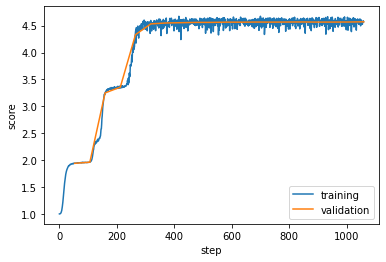

In [25]:
plt.plot(*vampnet.train_scores.T, label='training')
plt.plot(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

Given the trained model, we can transform our data and visualize the state probability in the $(\phi, \psi)$ plane.

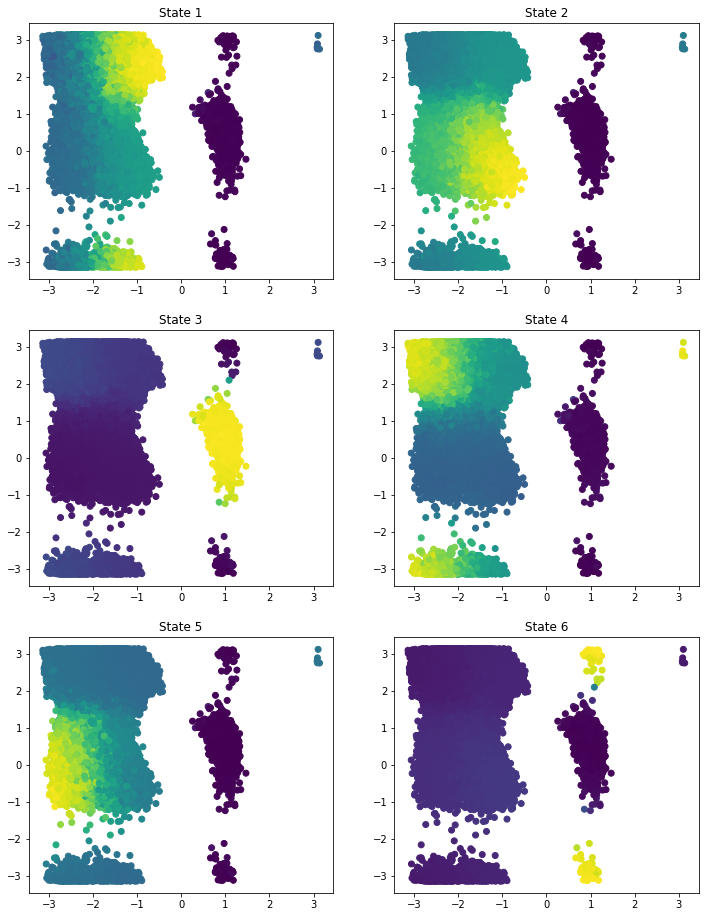

In [26]:
state_probabilities = model.transform(data[0])

f, axes = plt.subplots(3, 2, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(*dihedral[0][::5].T, c=state_probabilities[..., i][::5])
    ax.set_title(f'State {i+1}')

As well as cluster in the transformed space and assign each frame to its cluster center by taking the crisp assignment. Note that this step could also be performed by clustering with a potentially larger number of clusters.

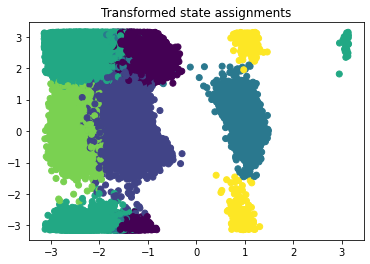

In [46]:
assignments = state_probabilities.argmax(1)
plt.scatter(*dihedral[0].T, c=assignments)
plt.title('Transformed state assignments');